In [1]:
import tqdm
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
plt.style.use('default')

from utils.model_measure import print_regression_measure, measure_regression
from sklearn.metrics import root_mean_squared_error

# 1. Dataset

a regression dataset

In [2]:
from sklearn.datasets import load_diabetes
data_X, data_Y = load_diabetes(return_X_y=True, as_frame=False)

n_samples = len(data_X)

# sample weights
rng = np.random.default_rng(seed=42)
data_weight = rng.normal(loc=0.0, scale=1.0, size=n_samples)
data_weight = np.abs(data_weight) + 1.0

train_idx, test_idx = train_test_split(range(n_samples), test_size=0.3, random_state=0)
train_X, test_X = data_X[train_idx], data_X[test_idx]
train_Y, test_Y = data_Y[train_idx], data_Y[test_idx]
train_weight, test_weight = data_weight[train_idx], data_weight[test_idx]

print('\nShape of dataset:', data_X.shape, data_Y.shape, data_weight.shape,
      '\nShape of training set:', train_X.shape, train_Y.shape, train_weight.shape,
      '\nShape of testing set:', test_X.shape, test_Y.shape, test_weight.shape)


Shape of dataset: (442, 10) (442,) (442,) 
Shape of training set: (309, 10) (309,) (309,) 
Shape of testing set: (133, 10) (133,) (133,)


Text(0.5, 1.0, 'Distribution of target')

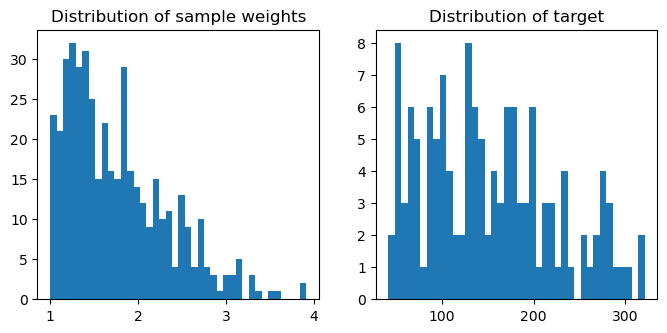

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5))

ax = axes[0]
ax.hist(data_weight, bins=40)
ax.set_title('Distribution of sample weights')

ax = axes[1]
ax.hist(test_Y, bins=40)
ax.set_title('Distribution of target')

# 2. Weighted bootstrap (bagging)



In [4]:
import utils.weighted_bagging_model
import importlib
importlib.reload(utils.weighted_bagging_model)

from utils.weighted_bagging_model import WeightedBaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [5]:
model = WeightedBaggingRegressor(
    estimator = DecisionTreeRegressor(),
    n_estimators = 100,
    bootstrap = True,
    bootstrap_features = True,
    max_samples = 1.0,
    max_features = 0.8,
    weighted_bootstrap = False,
    weighted_training = False,
    oob_score = True,
    random_state = None,
    n_jobs = 10,
    verbose = 0)

model.fit(train_X, train_Y)

WeightedBaggingRegressor(estimator=DecisionTreeRegressor(), max_features=0.8,
                         n_estimators=100, n_jobs=10, oob_score=True,
                         weighted_bootstrap=False, weighted_training=False)

#### (1) Out-of-bag (OOB) prediction

oob prediction and oob score (R2 score) are only available when `oob_score` is set to `True` and after calling `fit()` method.

- `oob_prediction_` : OOB prediction results for each training sample

In [6]:
print('OOB prediction:', model.oob_prediction_)
print('OOB score (R2):', model.oob_score_)

OOB prediction: [176.58333333  98.46153846 180.57575758 245.47058824 133.03448276
 118.85365854 169.02020202  93.61764706 226.40540541 161.7027027
 128.66666667 133.02380952  99.15151515  82.61290323  82.71428571
 151.24242424 122.07142857 151.77777778 124.91666667 230.75073314
 177.3        264.58823529 119.40540541 119.05128205 126.93333333
 137.89473684 204.69230769 245.51515152 185.8        106.38461538
 137.31578947 104.91176471 147.60606061 191.35294118 179.14285714
  92.64516129 106.28947368 152.97826087 256.43243243 186.5
 149.49333333 127.08571429 150.5952381  171.20588235 127.47058824
 216.93103448 224.04761905 257.51515152 125.80487805 138.41860465
 149.42307692 241.56818182  87.625       89.84210526 166.06976744
  76.67647059 108.90909091 274.37142857 198.91176471  70.31578947
 109.61904762  97.34285714 150.88148148  94.92857143 226.51162791
 201.58536585 139.14705882 173.55555556 252.71428571 164.7
 104.65714286  91.07407407 173.48648649  75.74285714 223.86206897
 259.15  

#### (2) Bootstrap indices

- `estimators_samples_` : accessing sample indices for each estimator

    - `estimators_samples__` : self-coded function to access sample indices for each estimator

- `estimators_features_` : accessing feature indices for each estimator

In [7]:
# sample indices
# built-in function
model.estimators_samples_
# self-coded function
model.estimators_samples__

print('\nDifference between two functions:')
for idx_1, idx_2 in zip(model.estimators_samples_, model.estimators_samples__):
    print(np.abs(idx_1 - idx_2).sum(), end=',')

# feature indices
print('\n\nFeature indices:')
print(model.estimators_features_)


Difference between two functions:
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Feature indices:
[array([6, 2, 9, 0, 4, 4, 0, 7], dtype=int32), array([8, 4, 8, 5, 6, 0, 3, 4], dtype=int32), array([4, 6, 8, 5, 4, 5, 9, 1], dtype=int32), array([4, 9, 2, 7, 3, 7, 1, 8], dtype=int32), array([5, 7, 6, 2, 5, 5, 1, 2], dtype=int32), array([9, 5, 3, 4, 5, 3, 4, 5], dtype=int32), array([4, 8, 3, 5, 8, 9, 9, 1], dtype=int32), array([6, 7, 1, 7, 1, 7, 7, 6], dtype=int32), array([9, 9, 1, 7, 8, 2, 6, 3], dtype=int32), array([6, 5, 0, 5, 8, 6, 2, 0], dtype=int32), array([9, 9, 4, 8, 1, 4, 6, 8], dtype=int32), array([6, 0, 4, 5, 2, 9, 8, 6], dtype=int32), array([0, 2, 9, 5, 0, 2, 2, 0], dtype=int32), array([5, 6, 2, 1, 9, 7, 4, 1], dtype=int32), array([1, 1, 8, 8, 4, 3, 4, 3], dtype=int32), array([8, 2, 4, 9, 9, 8, 1, 2], dtype=int32), array([2,

#### (3) Performance evaluation

In [8]:
def model_evaluation(model, train_X, train_Y, test_X, test_Y, train_weight, test_weight, weighted_fitting=False):
    
    if weighted_fitting:
        model.fit(train_X, train_Y, train_weight)
    else:
        model.fit(train_X, train_Y)
    
    measure = dict({'oob_rmse' : model.oob_score_})

    train_Y_pred = model.predict(train_X)
    test_Y_pred = model.predict(test_X)

    train_m = measure_regression(train_Y, train_Y_pred, train_weight)
    test_m  = measure_regression(test_Y, test_Y_pred, test_weight)

    measure.update({f'train_{k}' : v for k, v in train_m.items()})
    measure.update({f'test_{k}' : v for k, v in test_m.items()})
    
    return measure

In [9]:
peformance = {}

model.set_params(weighted_bootstrap=False, weighted_training=False)
peformance['BU-TU'] = model_evaluation(model, train_X, train_Y, test_X, test_Y, train_weight, test_weight, weighted_fitting=False)

model.set_params(weighted_bootstrap=True, weighted_training=False)
peformance['BW-TU'] = model_evaluation(model, train_X, train_Y, test_X, test_Y, train_weight, test_weight, weighted_fitting=True)

model.set_params(weighted_bootstrap=False, weighted_training=True)
peformance['BU-TW'] = model_evaluation(model, train_X, train_Y, test_X, test_Y, train_weight, test_weight, weighted_fitting=True)

model.set_params(weighted_bootstrap=True, weighted_training=True)
peformance['BW-TW'] = model_evaluation(model, train_X, train_Y, test_X, test_Y, train_weight, test_weight, weighted_fitting=True)

pd.DataFrame.from_dict(peformance).T

,oob_rmse,train_mae,train_mse,train_rmse,train_mape,train_r2,test_mae,test_mse,test_rmse,test_mape,test_r2
BU-TU,0.491557,17.335224,453.449235,21.294347,0.156256,0.928207,45.845292,3233.601685,56.864767,0.391788,0.349261
BW-TU,0.467906,16.754868,454.502036,21.319053,0.148647,0.912973,45.367738,3142.012591,56.053658,0.395300,0.364825
BU-TW,0.457981,17.933038,472.284295,21.732103,0.162415,0.924141,47.178200,3381.176932,58.147888,0.418356,0.322628
BW-TW,0.456652,17.083605,469.956156,21.678472,0.158381,0.910445,46.326715,3275.715030,57.233863,0.405381,0.334556


# 3. Comparison test

- Unweighted BaggingRegressor vs `sklearn.ensemble.BaggingRegressor`

- Unweighted BaggingRegressor vs `sklearn.ensemble.RandomForestRegressor`

Based on the model principle, if sample weights for bootstrapping process are not considered in `WeightedBaggingRegressor`, the two models should have the same performance.

Consider the randomization process of bootstrapping, repeated trials are conducted to evaluate the performance of two models.

In [10]:
def model_evaluation(model, train_X, train_Y, test_X, test_Y):

    model.fit(train_X, train_Y)

    measure = dict({'oob_r2' : model.oob_score_})

    train_Y_pred = model.predict(train_X)
    test_Y_pred = model.predict(test_X)

    train_m = measure_regression(train_Y, train_Y_pred)
    test_m  = measure_regression(test_Y, test_Y_pred)

    measure.update({f'train_{k}' : v for k, v in train_m.items()})
    measure.update({f'test_{k}' : v for k, v in test_m.items()})

    return measure
# =============================================================================

In [11]:
from utils.weighted_bagging_model import WeightedBaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

## 3.1 Compared with `sklearn.ensemble.BaggingRegressor`

In [12]:
params = {
    'estimator' : DecisionTreeRegressor(),
    'n_estimators' : 100,
    'random_state' : 42,
    'bootstrap' : True,
    'bootstrap_features' : True,
    'max_samples' : 1.0,
    'max_features' : 0.8,
    'oob_score' : True,
    'n_jobs' : 10,
    'verbose' : 0}


# Self-coded bagging regression
model_wb = WeightedBaggingRegressor(
    weighted_bootstrap = False, weighted_training = False,
    **params)

measure_wb = model_evaluation(model_wb, train_X, train_Y, test_X, test_Y)

# Bagging regression
model_br = BaggingRegressor(
    **params)

measure_br = model_evaluation(model_br, train_X, train_Y, test_X, test_Y)

#### (1) bootstrap sample indices and feature indices

In [13]:
print('\nDifference between two models:')
for wb_idx, br_idx in zip(model_wb.estimators_samples__, model_br.estimators_samples_):
    print(np.abs(wb_idx - br_idx).sum(), end=',')

print('\n\nDifference between two models:')
for wb_idx, br_idx in zip(model_wb.estimators_features_, model_br.estimators_features_):
    print(np.abs(wb_idx - br_idx).sum(), end=',')


Difference between two models:
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Difference between two models:
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

#### (2) Prediction results

In [14]:
print('\nDifference between two models:',
      '\nPrediction on training set:', np.sum(np.abs(model_wb.predict(train_X) - model_br.predict(train_X))),
      '\nPrediction on testing set:', np.sum(np.abs(model_wb.predict(test_X) - model_br.predict(test_X))),
      '\nOOB prediction:', np.sum(np.abs(model_wb.oob_prediction_ - model_br.oob_prediction_)))

print('\nOverall measure difference:',
      '\n', pd.Series(measure_wb) - pd.Series(measure_br))


Difference between two models: 
Prediction on training set: 0.0 
Prediction on testing set: 0.0 
OOB prediction: 0.0

Overall measure difference: 
 oob_r2        0.0
train_mae     0.0
train_mse     0.0
train_rmse    0.0
train_mape    0.0
train_r2      0.0
test_mae      0.0
test_mse      0.0
test_rmse     0.0
test_mape     0.0
test_r2       0.0
dtype: float64


## 3.2 Repeated trials

In [15]:
n_trials = 20

seeds = np.random.randint(0, 1e6, n_trials).tolist()
n_estimators = np.random.randint(100, 500, n_trials).tolist()

score_wb = []
score_br = []
score_rf = []

for seed, n_estimator in tqdm.tqdm(zip(seeds, n_estimators)):
    
    # Self-coded bagging regression
    model = WeightedBaggingRegressor(
        n_estimators = n_estimator,
        random_state = seed,
        estimator = DecisionTreeRegressor(),
        bootstrap = True,
        bootstrap_features = False,
        max_samples = 1.0,
        max_features = None,
        weighted_bootstrap = False, weighted_training = False,
        oob_score = True,
        n_jobs = 10, verbose = 0)

    measure = model_evaluation(model, train_X, train_Y, test_X, test_Y)
    measure.update({'seed' : seed, 'n_estimator' : n_estimator})
    score_wb.append(measure)
    
    # Bagging regression
    model = BaggingRegressor(
        estimator = DecisionTreeRegressor(),
        n_estimators = n_estimator,
        random_state = seed,
        bootstrap = True,
        bootstrap_features = False,
        max_samples = 1.0,
        max_features = 1.0,
        oob_score = True,
        n_jobs = 10, verbose = 0)

    measure = model_evaluation(model, train_X, train_Y, test_X, test_Y)
    measure.update({'seed' : seed, 'n_estimator' : n_estimator})
    score_br.append(measure)
    
    
    # Random forest regression
    model = RandomForestRegressor(
        n_estimators = n_estimator,
        random_state = seed,
        bootstrap = True,
        max_samples = 1.0,
        max_features = 1.0,
        oob_score = root_mean_squared_error,
        n_jobs = 10, verbose = 0)

    measure = model_evaluation(model, train_X, train_Y, test_X, test_Y)
    measure.update({'seed' : seed, 'n_estimator' : n_estimator})
    score_rf.append(measure)


score_wb = pd.DataFrame(score_wb)
score_br = pd.DataFrame(score_br)
score_rf = pd.DataFrame(score_rf)

20it [00:15,  1.33it/s]


## 3.3 Paired t-test of performance

In [16]:
# paired t-test
# Calculate the t-test on TWO RELATED samples of scores, a and b.
# This is a test for the null hypothesis that two related or repeated samples have identical average (expected) values.
# P > 0.05 : no enough evidence to reject the null hypothesis that model performance is the same
from scipy.stats import ttest_rel

for col in score_rf.columns:
    
    print(f'{col:>11}:')
          
    t, p = ttest_rel(score_wb[col], score_rf[col])
    print(f'WB v.s. RF: t = {t:>7.3f}, p = {p:.3f}', ' | ', end='')
    
    t, p = ttest_rel(score_wb[col], score_br[col])
    print(f'WB v.s. BR: t = {t:>7.3f}, p = {p:.3f}', ' | ', end='')
    
    t, p = ttest_rel(score_br[col], score_rf[col])
    print(f'BR v.s. RF: t = {t:>7.3f}, p = {p:.3f}', ' | ', )

     oob_r2:
WB v.s. RF: t = -465.792, p = 0.000  | WB v.s. BR: t =     nan, p = nan  | BR v.s. RF: t = -465.792, p = 0.000  | 
  train_mae:
WB v.s. RF: t =  -0.815, p = 0.425  | WB v.s. BR: t =     nan, p = nan  | BR v.s. RF: t =  -0.815, p = 0.425  | 
  train_mse:
WB v.s. RF: t =  -0.275, p = 0.786  | WB v.s. BR: t =     nan, p = nan  | BR v.s. RF: t =  -0.275, p = 0.786  | 
 train_rmse:
WB v.s. RF: t =  -0.256, p = 0.800  | WB v.s. BR: t =     nan, p = nan  | BR v.s. RF: t =  -0.256, p = 0.800  | 
 train_mape:
WB v.s. RF: t =  -0.517, p = 0.611  | WB v.s. BR: t =     nan, p = nan  | BR v.s. RF: t =  -0.517, p = 0.611  | 
   train_r2:
WB v.s. RF: t =   0.275, p = 0.786  | WB v.s. BR: t =     nan, p = nan  | BR v.s. RF: t =   0.275, p = 0.786  | 
   test_mae:
WB v.s. RF: t =   0.705, p = 0.489  | WB v.s. BR: t =     nan, p = nan  | BR v.s. RF: t =   0.705, p = 0.489  | 
   test_mse:
WB v.s. RF: t =   0.419, p = 0.680  | WB v.s. BR: t =     nan, p = nan  | BR v.s. RF: t =   0.419, p = 